In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.cluster import DBSCAN

In [2]:
data_dir = "DAS_data"
files = os.listdir(data_dir)
print(len(files))

2334


In [3]:
def normalize(a):
    a = (a - np.min(a))/(np.max(a) - np.min(a))
    return a

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.cluster import DBSCAN

def normalize(a):
    a = (a - np.min(a))/(np.max(a) - np.min(a))
    return a

def plot_detected_lines(path):
    orig_img = np.load(path).T
    img = normalize(orig_img)
    img[img<0.5] = 0
    img = (255*np.stack([img]*3, axis=-1)).astype(np.uint8)
    # Load and process image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)

    # Get (x, y) coordinates of all edge pixels
    points = np.column_stack(np.where(edges > 0))  # (y, x)
    points = points[:, ::-1]  # convert to (x, y)

    # Use DBSCAN to cluster edge points
    db = DBSCAN(eps=10, min_samples=20).fit(points)
    labels = db.labels_

    # For visualization
    result = img.copy()
    unique_labels = set(labels)
    print(f"Detected {len(unique_labels) - (1 if -1 in labels else 0)} line groups")

    for label in unique_labels:
        if label == -1:
            continue  # noise

        cluster_points = points[labels == label]
        x = cluster_points[:, 0]
        y = cluster_points[:, 1]

        if len(x) < 10:
            continue

        # Fit least squares line: y = mx + b
        A = np.vstack([x, np.ones(len(x))]).T
        m, b = np.linalg.lstsq(A, y, rcond=None)[0]

        # Filter only diagonal-ish lines
        if abs(m) < 0.2:
            continue

        # Start/end points for drawing
        x_start, x_end = np.min(x), np.max(x)
        y_start = int(m * x_start + b)
        y_end = int(m * x_end + b)

        cv2.line(result, (x_start, y_start), (x_end, y_end), (0, 0, 255), 2)
        print(f"[Group {label}] Slope: {m:.2f}, Start: ({x_start}, {y_start}), End: ({x_end}, {y_end})")

    # Top: Original image
    plt.subplot(2, 1, 1)
    plt.imshow(orig_img)
    plt.title("Original DAS plot")

    # Bottom: Result image
    plt.subplot(2, 1, 2)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title("Detected Diagonal Lines")
    plt.show()

Detected 7 line groups
[Group 3] Slope: -0.46, Start: (558, 41), End: (563, 38)
[Group 4] Slope: -0.57, Start: (367, 157), End: (535, 62)
[Group 5] Slope: -0.60, Start: (432, 155), End: (584, 64)


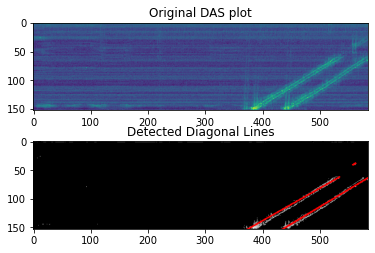

In [36]:
plot_detected_lines(os.path.join(data_dir, files[0]))

Detected 5 line groups
[Group 1] Slope: -0.59, Start: (327, 153), End: (489, 57)
[Group 2] Slope: 0.57, Start: (520, 128), End: (535, 137)
[Group 3] Slope: -0.45, Start: (554, 135), End: (563, 131)


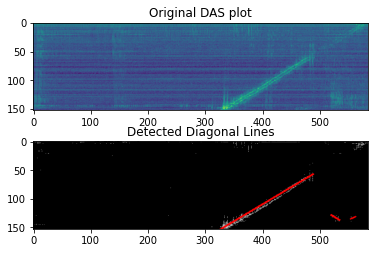

In [37]:
plot_detected_lines(os.path.join(data_dir, files[4]))

Detected 12 line groups
[Group 8] Slope: 2.37, Start: (104, 31), End: (107, 39)
[Group 10] Slope: -0.31, Start: (0, 77), End: (48, 62)
[Group 11] Slope: -0.53, Start: (288, 157), End: (467, 62)


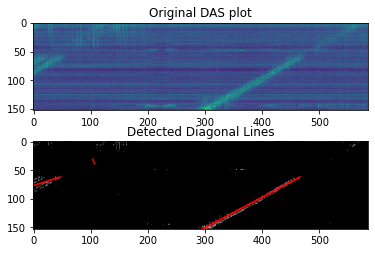

In [38]:
plot_detected_lines(os.path.join(data_dir, files[5]))